In [1]:
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt

##Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,OrdinalEncoder
from sklearn.impute import SimpleImputer

#test train split, Model building
from sklearn.model_selection import train_test_split
import scipy.sparse.linalg as ll
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,OrdinalEncoder
from sklearn.linear_model import LassoCV

#dimension reduction
from scipy.interpolate import BSpline

In [2]:
train = pd.read_csv("train.csv")
y = train["SalePrice"]
train = train.drop(columns=["SalePrice"])
test = pd.read_csv("test.csv")

#These columns are no important because of pooling
train = train.drop(columns=["Id","YrSold","YearBuilt", "YearRemodAdd", "YrSold", "MoSold"])

print(train.shape, test.shape, y.shape)

(1460, 75) (1459, 80) (1460,)


### Training data set contains 1460 rows and 80 columns
### Test data set contains 1460 rows and 80 columns
### Y contain response variable [SalePrice]

## Understanding Data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  RoofStyl

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Data Cleaning

### Preprocessing
### Imputing missing value, USE OrdinalEncoder for objects, SimpleImputer for continuous values

(1460, 43) (1460, 32) (1460, 75)


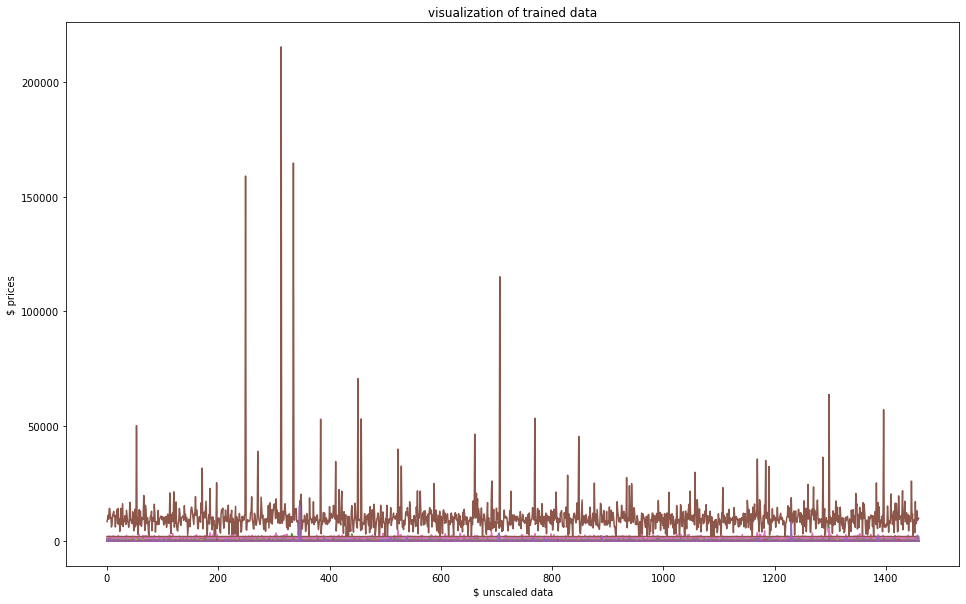

In [5]:
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

train_calssify = enc.fit_transform(train[train.columns[train.dtypes == object]])
train_continuous = imp.fit_transform(train[train.columns[train.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
print(train_calssify.shape, train_continuous.shape, train_processed.shape)
fig, ax = plt.subplots(figsize=(16, 10)) 
plt.title("visualization of trained data")
plt.ylabel("$ prices")
plt.xlabel("$ unscaled data")
plt.plot(train_processed)
plt.show()

## Not quite there yet
## Scale data

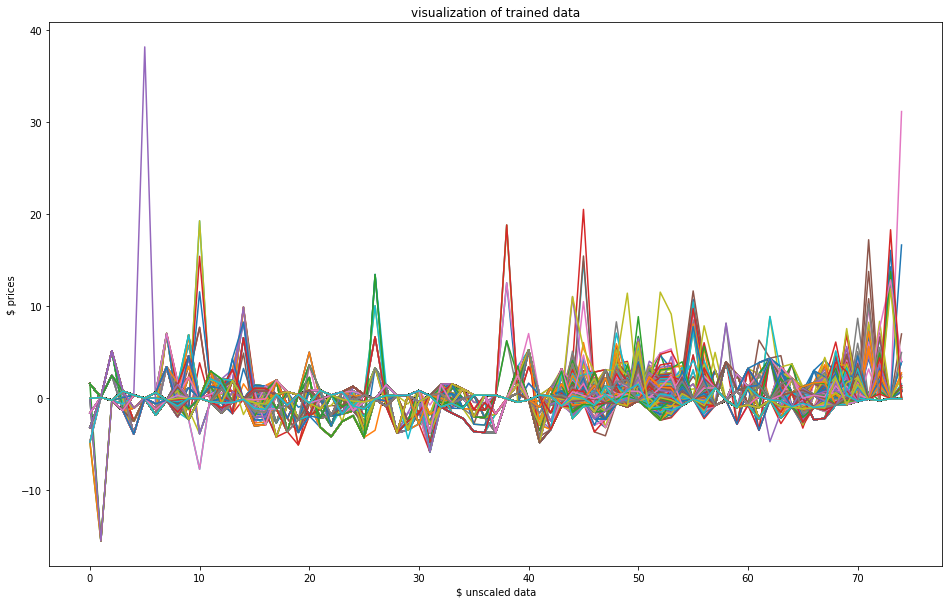

In [6]:
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())
fig, ax = plt.subplots(figsize=(16, 10))    
plt.plot(train_scaled.T)
plt.title("visualization of trained data")

plt.show()

## Feature Extraction

In [7]:
#################################
#lets rescale and run lasso again 
# 50 features
################################# 
train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)

rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)

#Looks like these columns can be excluded, lets take a look at them and see which ones they are
train_new = train.drop(columns=train.columns[rem_col])

#################################
#lets rescale and run lasso again 
# 40 features
#################################
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_new[train_new.columns[train_new.dtypes == object]])
train_continuous = imp.fit_transform(train_new[train_new.columns[train_new.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)
rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)
train_new_2 = train_new.drop(columns=train_new.columns[rem_col])

#################################
#lets rescale and run lasso again 
# 34 features
#################################
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_new_2[train_new_2.columns[train_new_2.dtypes == object]])
train_continuous = imp.fit_transform(train_new_2[train_new_2.columns[train_new_2.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)
rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)
train_new_3 = train_new_2.drop(columns=train_new_2.columns[rem_col])

#################################
#lets rescale and run lasso again 
# 34 features
#################################
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_new_3[train_new_3.columns[train_new_3.dtypes == object]])
train_continuous = imp.fit_transform(train_new_3[train_new_3.columns[train_new_3.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)
rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)
train_new_4 = train_new_3.drop(columns=train_new_3.columns[rem_col])

#################################
#lets rescale and run lasso again 
# 30 features
#################################
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_new_4[train_new_4.columns[train_new_4.dtypes == object]])
train_continuous = imp.fit_transform(train_new_4[train_new_4.columns[train_new_4.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)
rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)
train_new_5 = train_new_4.drop(columns=train_new_4.columns[rem_col])

#################################
#lets rescale and run lasso again 
# 23 features
#################################
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_new_5[train_new_5.columns[train_new_5.dtypes == object]])
train_continuous = imp.fit_transform(train_new_5[train_new_5.columns[train_new_5.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)
rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)
train_new_6 = train_new_5.drop(columns=train_new_5.columns[rem_col])


#################################
#lets rescale and run lasso again 
# 23 features
#################################
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_new_6[train_new_6.columns[train_new_6.dtypes == object]])
train_continuous = imp.fit_transform(train_new_6[train_new_6.columns[train_new_6.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

train_scaled_new = train_scaled.copy()
selector = SelectFromModel(estimator=LassoCV(eps=0.000011, tol=1e-4, cv=10, n_alphas=500))\
            .fit(train_scaled_new,y)
rem_col = np.argwhere(selector.estimator_.coef_ ==  0).reshape(-1)
train_new_7 = train_new_6.drop(columns=train_new_6.columns[rem_col])


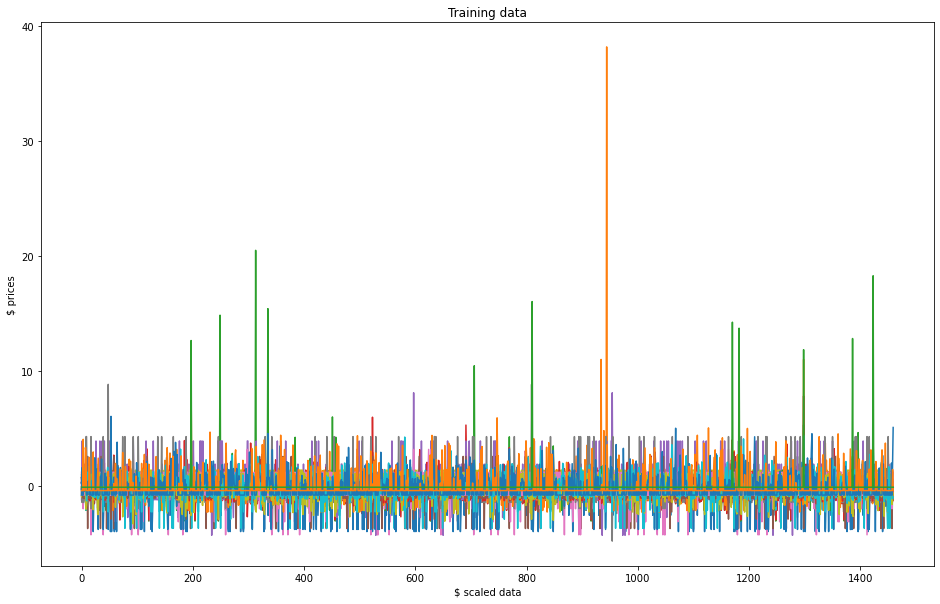

In [14]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.title("Training data")
plt.ylabel("$ prices")
plt.xlabel("$ scaled data")
plt.plot(train_scaled)
plt.show()

## Prepare Data

In [9]:
import numpy as np
from scipy import stats


In [10]:
train_prep = train_new_7.copy()
enc = OrdinalEncoder(encoded_missing_value=-1)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_calssify = enc.fit_transform(train_prep[train_prep.columns[train_prep.dtypes == object]])
train_continuous = imp.fit_transform(train_prep[train_prep.columns[train_prep.dtypes != object]])
train_processed = np.hstack((train_calssify, train_continuous))
scaler = StandardScaler().fit(train_processed.copy())
train_scaled = scaler.transform(train_processed.copy())

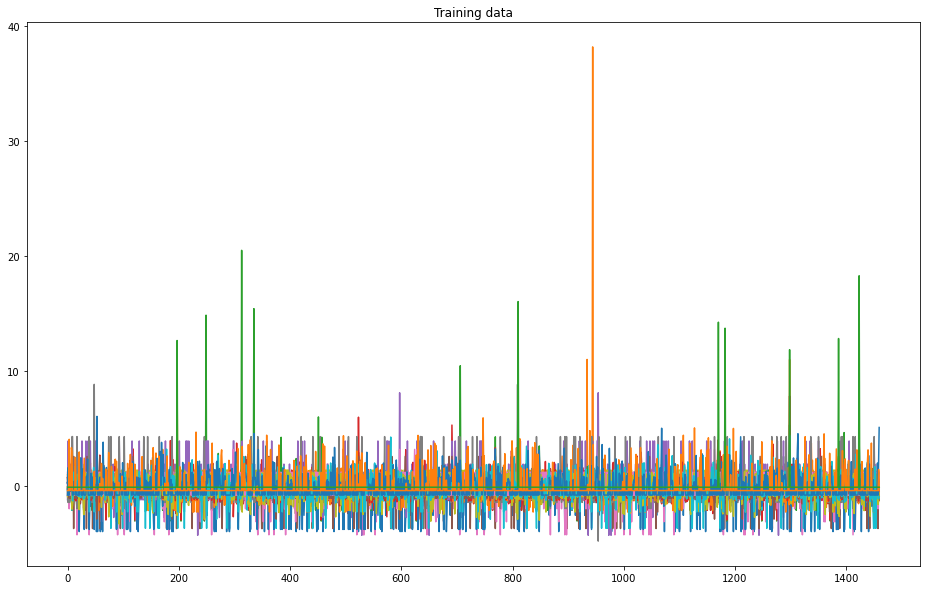

In [11]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.title("Training data")
plt.plot(train_scaled)
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(train_scaled,y, test_size=0.20, random_state=25)
reg = LinearRegression().fit(X_train, y_train)
print(f"Training Score {reg.score(X_train, y_train)}")
print(f"Test Score {reg.score(X_test, y_test)}")

Training Score 0.7503290629334749
Test Score 0.7295157187845747
